## Decision Tree Post-Pruning

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf

df = pd.read_csv('dataset/df_clean.csv')


ModuleNotFoundError: No module named 'imblearn'

Split del dataset pulito ed encodato

In [17]:
# Definizione di X e y
X = df.drop(['Crime_Category', 'Crime_Category_Encoded'], axis=1)
y = df['Crime_Category_Encoded']

In [18]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Prima devo trovare i valori di ccp_alpha

In [ ]:
# mi dà una lista di valori ccp_alpha crescenti
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train) 
# assegna i risultati alla variabile ccp_alpha
ccp_alphas = path.ccp_alphas

Addestramento di più alberi con ccp_alpha

In [21]:
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    trees.append(clf)


In [22]:
# Valutazione di ogni albero sull'insieme di test
test_scores = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]

Migliore Albero Post-Pruned

In [23]:
best_index = test_scores.index(max(test_scores))
best_tree = trees[best_index]
print(f"Miglior ccp_alpha: {ccp_alphas[best_index]}")

Miglior ccp_alpha: 0.0001392322954822955


In [29]:
# Creiamo l'albero e bilanciamo le classi
best_tree = DecisionTreeClassifier(
    random_state=42,
    ccp_alpha=0.0001392322954822955,
    class_weight='balanced'
)
best_tree.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


              precision    recall  f1-score   support

           0       0.36      0.56      0.43        45
           1       0.23      0.27      0.25       362
           2       0.35      0.66      0.46       271
           3       0.05      0.11      0.07        36
           4       0.94      0.80      0.86      2333
           5       0.75      0.75      0.75       953

    accuracy                           0.72      4000
   macro avg       0.45      0.52      0.47      4000
weighted avg       0.78      0.72      0.74      4000



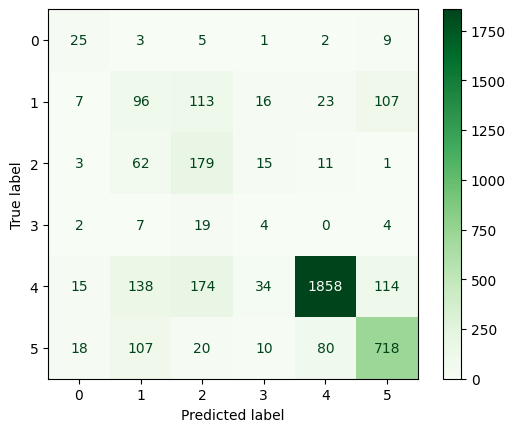

In [30]:
# Valutazione Modello
y_pred = best_tree.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test, cmap='Greens')

### Punti forti
Property Crimes (classe 4) ha un f1-score altissimo (0.86) = il modello la classifica molto bene.

Violent Crimes (classe 5) ha buoni risultati (f1 = 0.75).

Fraud and White-Collar Crimes (classe 2) migliora col bilanciamento (recall 0.66, f1 = 0.46).

### Criticità
Other Crimes (classe 3) = praticamente non viene riconosciuta (f1 = 0.07).

Crimes against Public Order (classe 1) ha ancora f1 = 0.25.

Crimes against Persons (classe 0) = piccolo campione (support = 45) ma almeno f1 = 0.43.

### Prime Osservazioni
Il modello con class_weight='balanced' ha aiutato molto le classi meno frequenti, in particolare classe 2.

Le classi 4 e 5 dominano la performance totale = il modello rischia di essere trainato da esse.

Alcune classi (1 e 3) restano problematiche:

Si potrebbe considerare **SMOTE** per oversampling delle classi minoritarie

In [ ]:
# Applichiamo SMOTE solo alle classi 1 e 3

# Isolo le classi 1 e 3
mask_minority = y_train.isin([1, 3])
X_minority = X_train[mask_minority]
y_minority = y_train[mask_minority]

# SMOTE solo su quelle
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_minority, y_minority)

# Unisco i dati SMOTE ai dati originali
X_train_bal = pd.concat([X_train, X_smote], axis=0)
y_train_bal = pd.concat([y_train, y_smote], axis=0)


In [ ]:

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

y_pred = rf.predict(X_test)
